# HR PREDICTION OF PROMOTION | COMPLETE PIPELINE
### This Entire analysis will try to predict a promotion for HR department.

## Steps
* <a href="#loading_libs">Loading Libs</a>
* <a href="#eda">Exploratory Data Analysis</a>
* <a href="#pipeline">Spliting Data + Pipeline creation</a>
* <a href="#fit_predict">Fitting and Predicting</a>
* <a href="#nesxt_steps">Next Steps</a>

<h2 id="loading_libs">Loading Libs</h2>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading Data - We are gonna use just train test for this model and split it
df = pd.read_csv('/kaggle/input/hranalysis/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


<h2 id="eda">Exploratory Data Analysis</h2>

In [3]:
# Checking null values
df.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [4]:
# Let's skip Na value for is_promoted column
df = df.dropna(subset='is_promoted')

In [5]:
# Checking duplicated values
df.duplicated().sum()

0

In [6]:
# let's see how man education levels we have
df['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [7]:
education_levels = {
    "Master's & above":3,
    "Bachelor's":2,
    "Below Secondary":1
}
df['education'] = df['education'].map(education_levels)

In [8]:
# Let's see how many regions we have
df['region'].value_counts()

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

In [9]:
# We need to check some statistics of data to understand a bit more about them
df.describe()

,employee_id,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,52399.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,2.269471,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.477060,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,2.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,2.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,3.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,3.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [10]:
num_cols = df.select_dtypes(exclude='object').columns

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/si

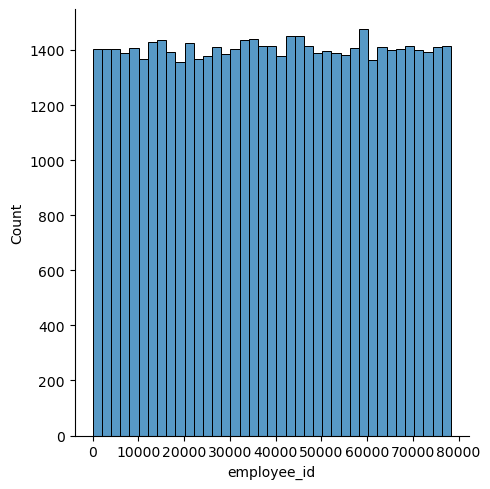

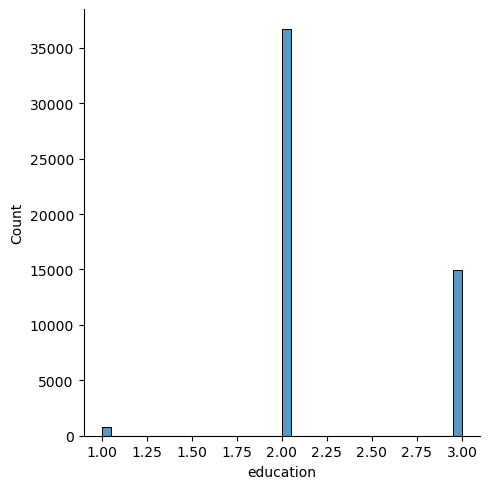

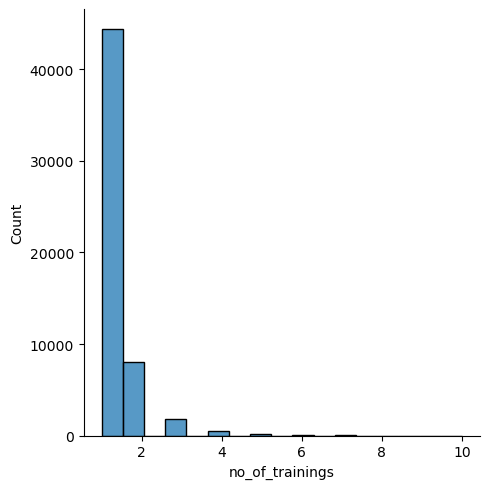

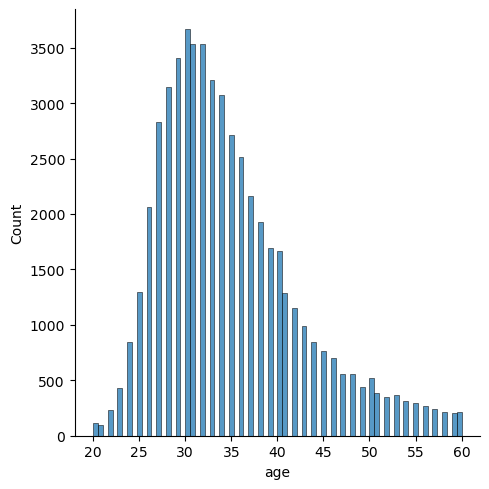

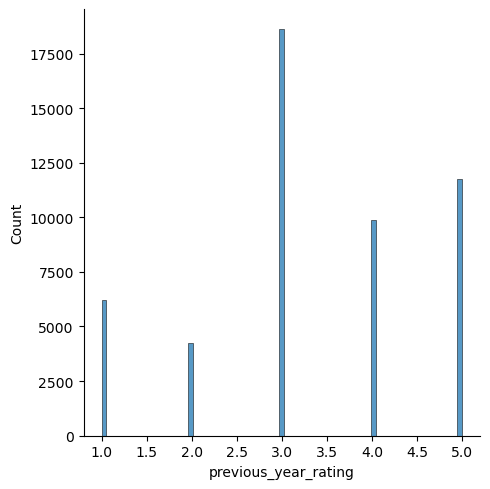

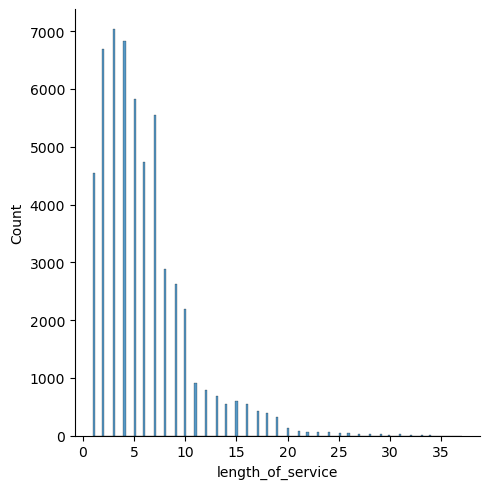

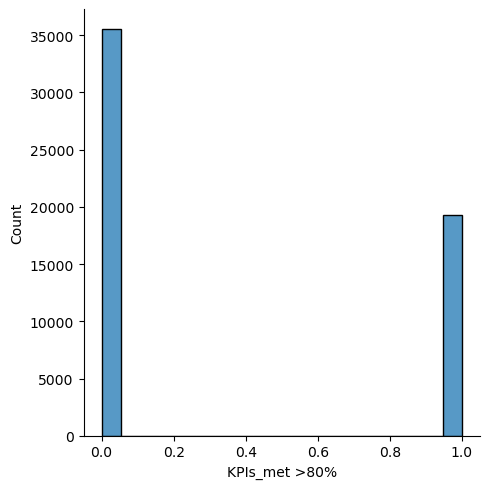

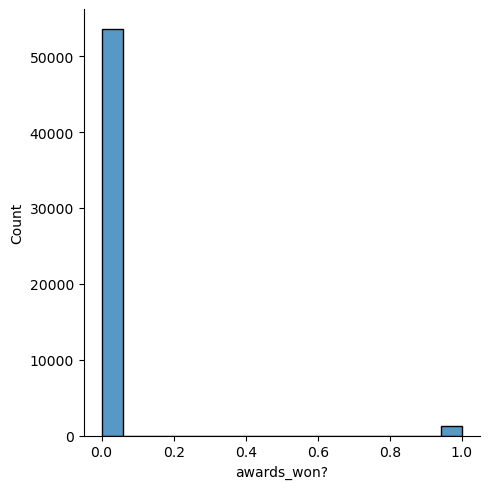

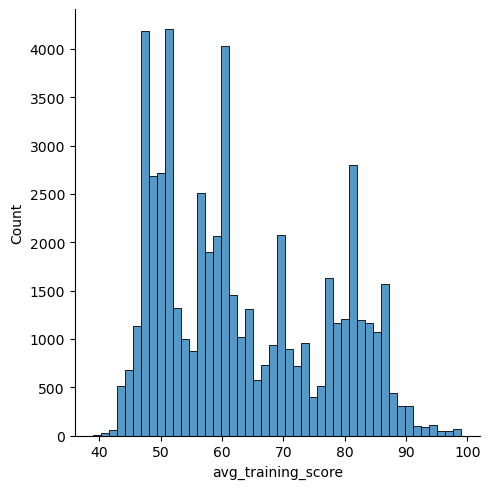

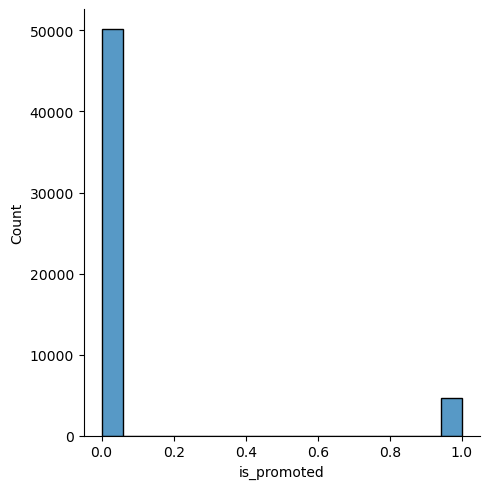

In [11]:
for pl in num_cols:
    sns.displot(data=df, x = pl)

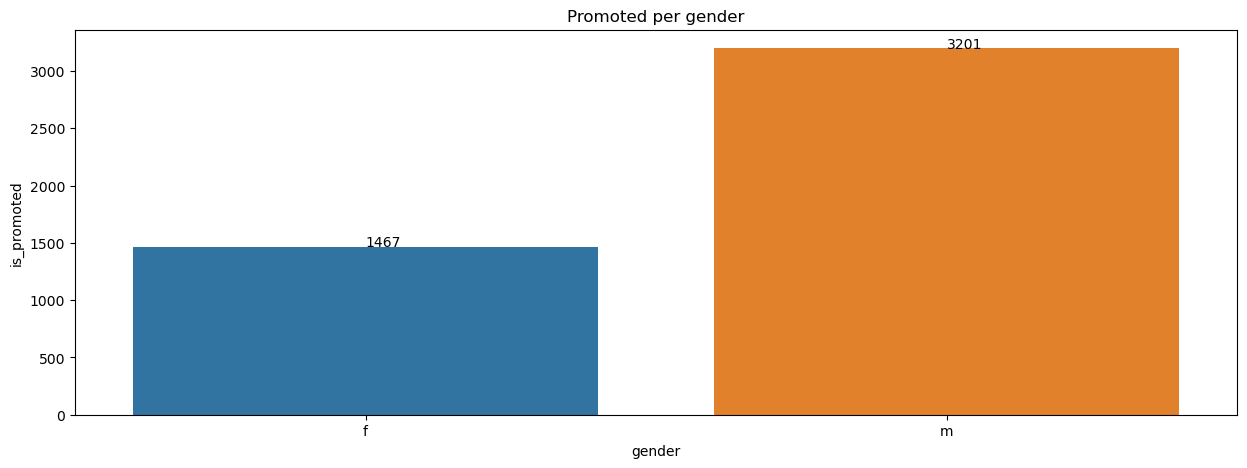

In [12]:
df_plot = df.groupby('gender')['is_promoted'].sum().reset_index()
plt.figure(figsize=(15,5))
sns.barplot(data = df_plot, x = 'gender', y = 'is_promoted')
plt.title('Promoted per gender')
for i, v in enumerate(df_plot.is_promoted):
    plt.text(x = i, y = v, s = v)

Text(0.5, 1.0, 'Promoted per Department per Gender')

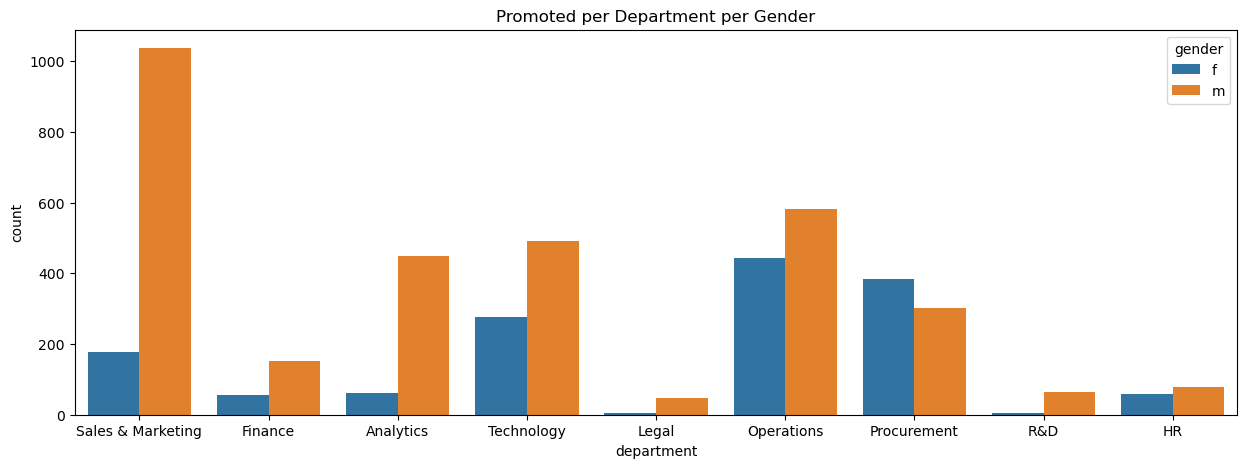

In [13]:
plt.figure(figsize=(15,5))
sns.countplot(data = df.query('is_promoted == 1'), x = 'department', hue='gender')
plt.title('Promoted per Department per Gender')

([<matplotlib.axis.XTick at 0x7d2b90822770>,
 [Text(0, 0, 'Below Secondary'),
  Text(1, 0, 'Bachelors'),
  Text(2, 0, 'Masters')])

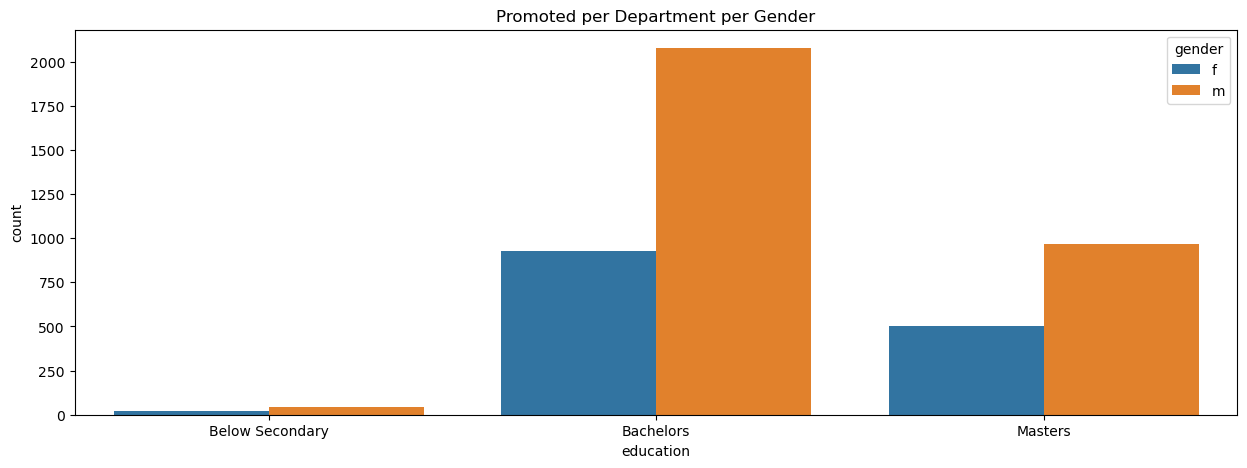

In [14]:
plt.figure(figsize=(15,5))
sns.countplot(data = df.query('is_promoted == 1'), x = 'education', hue='gender')
plt.title('Promoted per Department per Gender')
plt.xticks(ticks=[0,1,2],labels=('Below Secondary','Bachelors','Masters'))

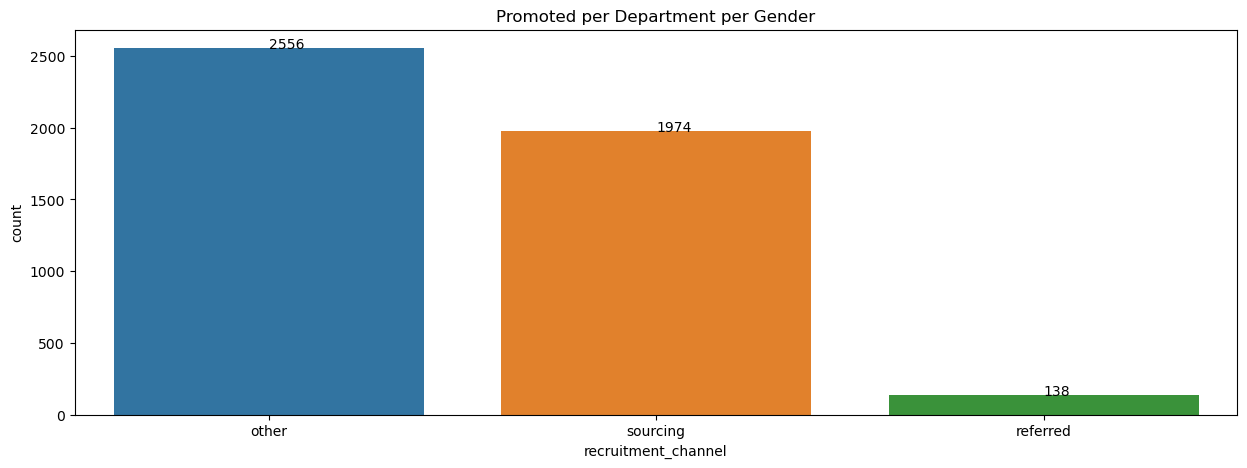

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(data = df.query('is_promoted == 1'), x = 'recruitment_channel',
              order= df.query('is_promoted == 1').recruitment_channel.value_counts().index)
plt.title('Promoted per Department per Gender')
for i, v in enumerate(df.query('is_promoted == 1').recruitment_channel.value_counts()):
    plt.text(x = i, y = v, s = v)

In [16]:
df.corr()[df.corr() > 0.5]

/tmp/ipykernel_21/3821921184.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()[df.corr() > 0.5]


,employee_id,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_trainings,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,1.000000,NaN,0.657111,NaN,NaN,NaN,NaN
previous_year_rating,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
length_of_service,NaN,NaN,NaN,0.657111,NaN,1.000000,NaN,NaN,NaN,NaN
KPIs_met >80%,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
awards_won?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
avg_training_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
is_promoted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


<h2 id="pipeline">Spliting Data + Pipeline creation</h2>

In [17]:
df = df.drop(columns=['employee_id','region'])

In [18]:
X = df.drop(columns=['is_promoted'])
y = df['is_promoted']

In [19]:
num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size= 0.75, random_state=92)

In [21]:
categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_transformer', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('knn_imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

In [22]:
preprocessing_pipeline = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
]
    )

In [23]:
param_grid = {
    'svm__tol':[0.001, 0.0001],
    'svm__C':[0.1, 0.01]
}

<h2 id="fit_predict">Fitting Pipeline</h2>

In [24]:
final_pipeline = Pipeline(steps=[
    ('preprocess',preprocessing_pipeline),
    ('svm', LinearSVC())
])

grid_search = GridSearchCV(final_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('knn_imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['education', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('cat_transformer',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['department', 'gender', 'recruitment_channel'], dtype='object'))])),
                                       ('svm', LinearSVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 0.01], 'svm__tol': [0.001, 0.0001]},
             scoring='accuracy')

In [25]:
# Let's see our best score
print(f'We had an accuracy of {grid_search.best_score_ * 100:.2f}%')

We had an accuracy of 93.23%


In [26]:
# Getting the best pipeline
best_pipeline = grid_search.best_estimator_

In [27]:
# Predicting promotions
predictions = best_pipeline.predict(x_test)

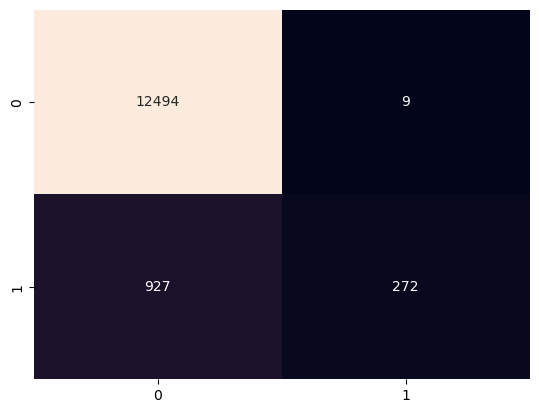

In [28]:
# Let's see our confusion matrix
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='.5g',cbar=False)
plt.show()

In [29]:
coefs = best_pipeline.named_steps['svm'].coef_

In [30]:
names = best_pipeline.named_steps['preprocess'].get_feature_names_out()

Text(0.5, 1.0, 'Feature Importances')

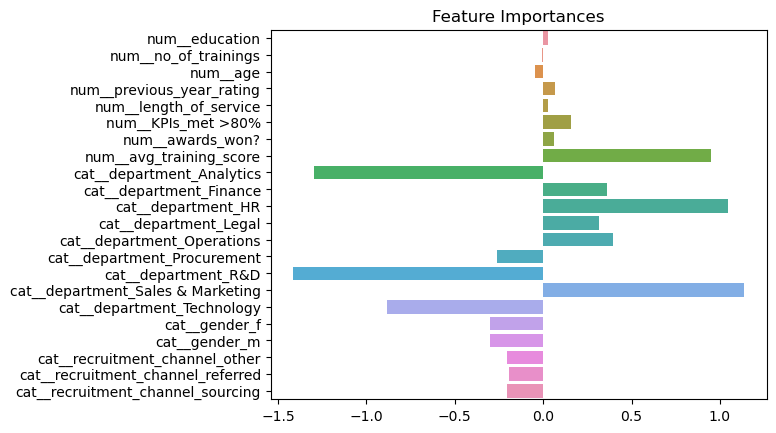

In [31]:
sns.barplot(y = names, x = coefs[0].tolist())
plt.title('Feature Importances')

### Coefficient Magnitude:
The magnitude of the coefficient indicates the
importance of the corresponding feature in determining the class labels.
A larger magnitude suggests a stronger influence on the decision boundary.

### Sign of the Coefficient:
The sign (positive or negative) of the coefficient
indicates the direction of the influence of the feature on the predicted
class label. For a positive coefficient, an increase in the feature value
will likely lead to a higher predicted probability of one class, and for
a negative coefficient, an increase in the feature value will likely
lead to a lower predicted probability of that class.

###    Coefficient Interpretation:
The coefficients' interpretation depends on the
scaling of the features. If the features are standardized (scaled to have
zero mean and unit variance), then the magnitude of the coefficient
reflects the importance of each feature relative to one standard deviation
change. If the features are not standardized, the magnitude's
interpretation is not as straightforward, as it depends on the original
scale of the features.





<h2 id = "next_steps">Next Steps</h2>
After all this steps we would generate a pickle file and build an API to put this model in production